In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import networkx as nx

In [2]:
def load_alias_map(path):
    # Step 1: collect all alias sets
    alias_groups = []

    with open(path, "r") as f:
        for line in f:
            aliases = set(t.strip() for t in line.strip().split(","))
            # Try to merge with an existing group if any overlap
            merged = False
            for group in alias_groups:
                if not aliases.isdisjoint(group):
                    group.update(aliases)
                    merged = True
                    break
            if not merged:
                alias_groups.append(aliases)

    # Step 2: resolve each group to a canonical term (e.g., shortest one)
    alias_map = {}
    for group in alias_groups:
        canonical = min(group, key=len) 
        for alias in group:
            alias_map[alias] = canonical

    return alias_map

# Load dataset
raw_dir = "/mnt/lts4/scratch/home/mmonteir/dir_graph_gen/DirectedGraphGen/data/visual_genome/raw"

# Create a dictionary of synonyms
object_alias_map = load_alias_map(os.path.join(raw_dir, "object_alias.txt"))
print("\n")
relationship_alias_map = load_alias_map(os.path.join(raw_dir, "relationship_alias.txt"))

In [3]:
# Load datasets
with open(os.path.join(raw_dir, "objects.json"), "r") as f:
    objects_data = json.load(f)

with open(os.path.join(raw_dir, "relationships.json"), "r") as f:
    relationships_data = json.load(f)

with open(os.path.join(raw_dir, "attributes.json"), "r") as f:
    attributes_data = json.load(f)

In [4]:
# quick testing: shorten data for testing
# objects_data = objects_data[:10]
# relationships_data = relationships_data[:10]

### Explore a bit the data

In [5]:
print("relationships_data")
type(relationships_data)
print(relationships_data[0])
print(relationships_data[0].keys())
# Double check if there are no duplicate image_ids
image_ids = [r["image_id"] for r in tqdm(relationships_data, desc="Checking uniqueness")]
if len(image_ids) != len(set(image_ids)):
    raise ValueError("Duplicate image_ids found.")

# Check if relationships are in order
# cur_image_id = 0
# for relationship in tqdm(relationships_data, desc="Checking relationships data"):
#     # Check if the image_id is in order
#     # If not, raise an error
#     if cur_image_id +1 != relationship["image_id"]:
#         raise ValueError(f"Relationships: Image ID mismatch: {cur_image_id + 1} != {relationship['image_id']}")
#     cur_image_id += 1
# Relationships are not in order, so we cannot use the index as the image_id

print("objects_data")
type(objects_data)
print(objects_data[0])
print(objects_data[0].keys())
# Double check if there are no duplicate image_ids
image_ids = [o["image_id"] for o in tqdm(objects_data, desc="Checking uniqueness")]
if len(image_ids) != len(set(image_ids)):
    raise ValueError("Duplicate image_ids found.")
# Check if objects are in order
# cur_image_id = 0
# for obj in tqdm(objects_data, desc="Checking objects data"):
#     # Check if the image_id is in order
#     # If not, raise an error
#     if obj["image_id"] != cur_image_id +1:
#         raise ValueError(f"Objects: Image ID mismatch: {obj['image_id']} != {cur_image_id}")
#     cur_image_id += 1
# Objects are not in order, so we cannot use the index as the image_id

print("attributes_data")
type(attributes_data)
print(attributes_data[0])
print(attributes_data[0].keys())
print(attributes_data[0]["image_id"])
print(attributes_data[0]["attributes"][0].keys())
print("attributes: ", attributes_data[0]["attributes"][0]["attributes"])
print("synsets: ", attributes_data[0]["attributes"][0]["synsets"])
print("names: ", attributes_data[0]["attributes"][0]["names"])
print("object_id: ", attributes_data[0]["attributes"][0]["object_id"])

relationships_data
{'relationships': [{'predicate': 'ON', 'object': {'h': 290, 'object_id': 1058534, 'merged_object_ids': [5046], 'synsets': ['sidewalk.n.01'], 'w': 722, 'y': 308, 'x': 78, 'names': ['sidewalk']}, 'relationship_id': 15927, 'synsets': ['along.r.01'], 'subject': {'name': 'shade', 'h': 192, 'synsets': ['shade.n.01'], 'object_id': 5045, 'w': 274, 'y': 338, 'x': 119}}, {'predicate': 'wears', 'object': {'h': 28, 'object_id': 1058525, 'merged_object_ids': [5048], 'synsets': ['shoe.n.01'], 'w': 48, 'y': 485, 'x': 388, 'names': ['shoes']}, 'relationship_id': 15928, 'synsets': ['wear.v.01'], 'subject': {'name': 'man', 'h': 262, 'synsets': ['man.n.01'], 'object_id': 1058529, 'w': 60, 'y': 249, 'x': 238}}, {'predicate': 'has', 'object': {'name': 'headlight', 'h': 15, 'synsets': ['headlight.n.01'], 'object_id': 5050, 'w': 23, 'y': 366, 'x': 514}, 'relationship_id': 15929, 'synsets': ['have.v.01'], 'subject': {'name': 'car', 'h': 98, 'synsets': ['car.n.01'], 'object_id': 5049, 'w': 7

Checking uniqueness: 100%|██████████| 108077/108077 [00:00<00:00, 1412107.82it/s]


objects_data
{'image_id': 1, 'objects': [{'synsets': ['tree.n.01'], 'h': 557, 'object_id': 1058549, 'merged_object_ids': [], 'names': ['trees'], 'w': 799, 'y': 0, 'x': 0}, {'synsets': ['sidewalk.n.01'], 'h': 290, 'object_id': 1058534, 'merged_object_ids': [5046], 'names': ['sidewalk'], 'w': 722, 'y': 308, 'x': 78}, {'synsets': ['building.n.01'], 'h': 538, 'object_id': 1058508, 'merged_object_ids': [], 'names': ['building'], 'w': 222, 'y': 0, 'x': 1}, {'synsets': ['street.n.01'], 'h': 258, 'object_id': 1058539, 'merged_object_ids': [3798578], 'names': ['street'], 'w': 359, 'y': 283, 'x': 439}, {'synsets': ['wall.n.01'], 'h': 535, 'object_id': 1058543, 'merged_object_ids': [], 'names': ['wall'], 'w': 135, 'y': 1, 'x': 0}, {'synsets': ['tree.n.01'], 'h': 360, 'object_id': 1058545, 'merged_object_ids': [], 'names': ['tree'], 'w': 476, 'y': 0, 'x': 178}, {'synsets': ['shade.n.01'], 'h': 189, 'object_id': 5045, 'merged_object_ids': [], 'names': ['shade'], 'w': 274, 'y': 344, 'x': 116}, {'syn

Checking uniqueness: 100%|██████████| 108077/108077 [00:00<00:00, 1832568.44it/s]

attributes_data
{'image_id': 1, 'attributes': [{'synsets': ['clock.n.01'], 'h': 339, 'object_id': 1058498, 'names': ['clock'], 'w': 79, 'attributes': ['green', 'tall'], 'y': 91, 'x': 421}, {'synsets': ['street.n.01'], 'h': 262, 'object_id': 5046, 'names': ['street'], 'w': 714, 'attributes': ['sidewalk'], 'y': 328, 'x': 77}, {'synsets': ['shade.n.01'], 'h': 192, 'object_id': 5045, 'names': ['shade'], 'w': 274, 'y': 338, 'x': 119}, {'synsets': ['man.n.01'], 'h': 262, 'object_id': 1058529, 'names': ['man'], 'w': 60, 'y': 249, 'x': 238}, {'synsets': ['gym_shoe.n.01'], 'h': 26, 'object_id': 5048, 'names': ['sneakers'], 'w': 52, 'attributes': ['grey'], 'y': 489, 'x': 243}, {'synsets': ['headlight.n.01'], 'h': 15, 'object_id': 5050, 'names': ['headlight'], 'w': 23, 'attributes': ['off'], 'y': 366, 'x': 514}, {'synsets': ['car.n.01'], 'h': 98, 'object_id': 5049, 'names': ['car'], 'w': 74, 'y': 315, 'x': 479}, {'synsets': ['bicycle.n.01'], 'h': 34, 'object_id': 5051, 'names': ['bike'], 'w': 28,

In [6]:
# Analyze relationships
relationship_counter = Counter()
for image_dict in relationships_data:
    for relationship in image_dict["relationships"]:
        predicate = relationship["predicate"]
        canonical_predicate = relationship_alias_map.get(predicate, predicate)
        relationship_counter[canonical_predicate] += 1

In [7]:
# Analyze objects
obj_counter = Counter()
for image_dict in tqdm(objects_data):
    for obj_list in image_dict["objects"]:
        # Simplification: if more than one name, pick the most common
        for obj in obj_list["names"]:
            canonical_obj = object_alias_map.get(obj, obj)
            obj_counter[canonical_obj] += 1

100%|██████████| 108077/108077 [00:01<00:00, 63330.81it/s]


In [8]:
# Check more common keys
def plot_counter(counter, top_k=None):
    most_common = counter.most_common(top_k)
    labels, counts = zip(*most_common)

    plt.figure(figsize=(10, len(labels) * 0.4))
    plt.barh(labels, counts)
    plt.gca().invert_yaxis()  # most common on top
    plt.xlabel("Count")
    plt.title("Most Common Items")
    plt.tight_layout()
    plt.show()

def plot_cumulative_counter(counter, x_range=None):
    most_common = counter.most_common()
    labels, counts = zip(*most_common)
    total = sum(counts)
    cumulative = [sum(counts[:i+1]) / total for i in range(len(counts))]

    # Full range by default
    if x_range is None:
        start, end = 0, len(cumulative)
    else:
        start, end = x_range

    x = range(start + 1, end + 1)
    y = cumulative[start:end]

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, marker='o')
    plt.xlabel("Rank")
    plt.ylabel("Cumulative Proportion")
    plt.title(f"Cumulative Distribution (Rank {start+1} to {end})")
    plt.grid(True, which='major', linestyle='-', linewidth=0.5)
    plt.grid(True, which='minor', linestyle='--', linewidth=0.3)
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()




### Distribution for Relationships

Number of different relationships: 34137


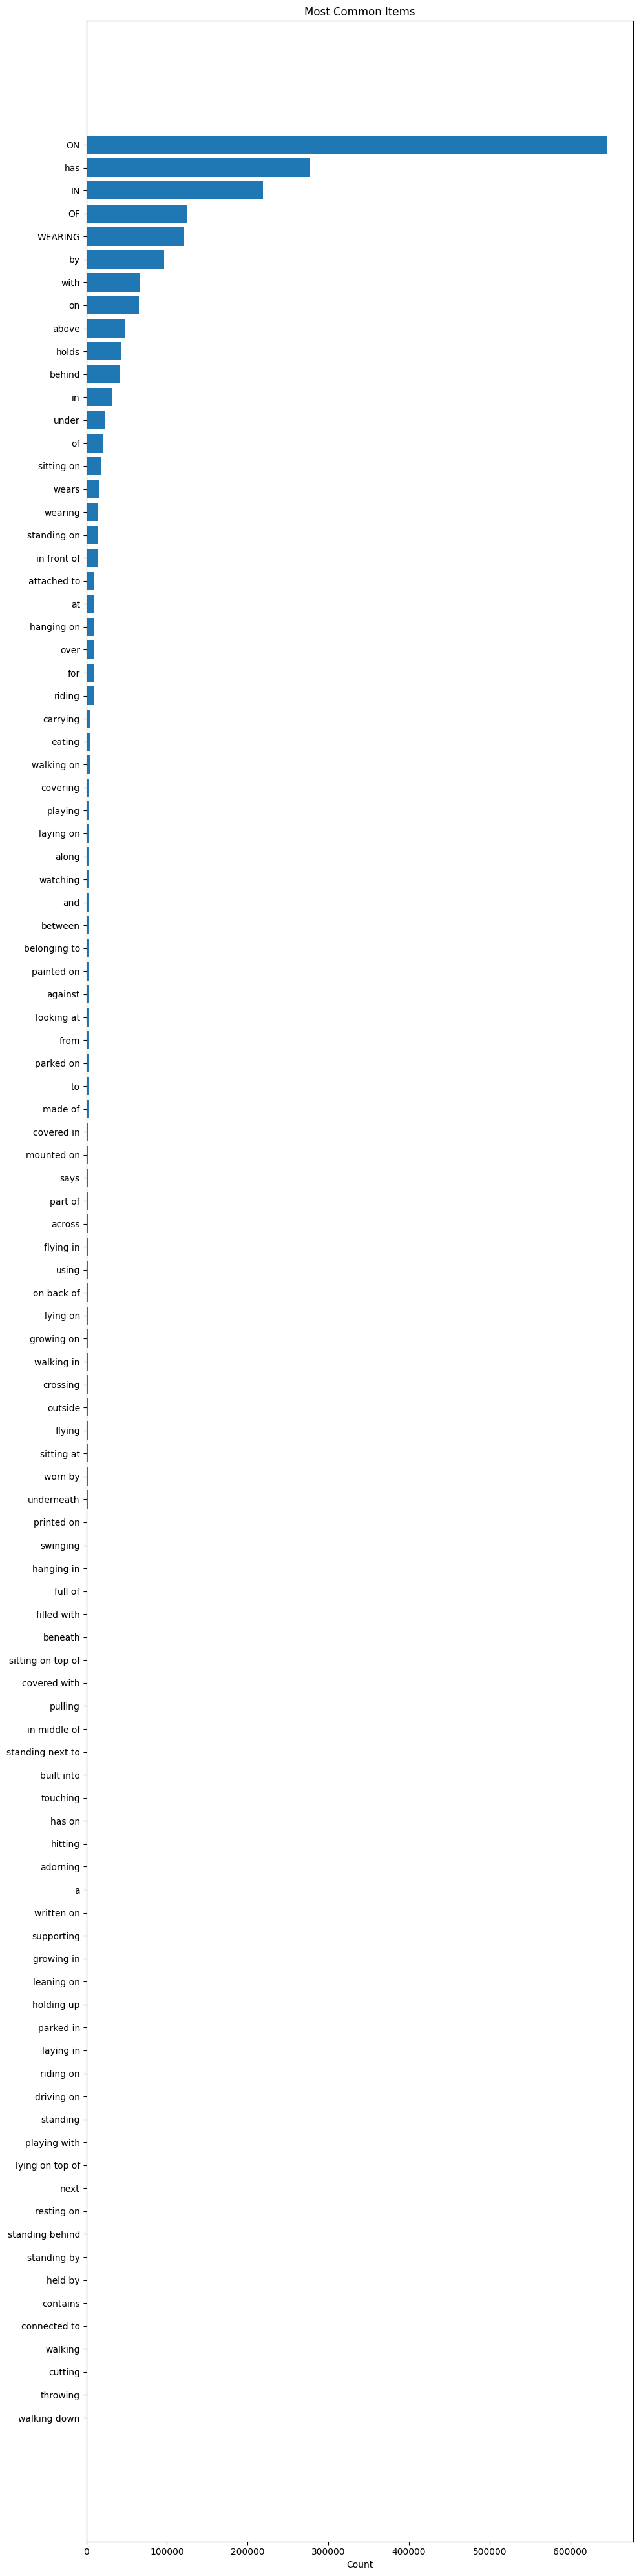

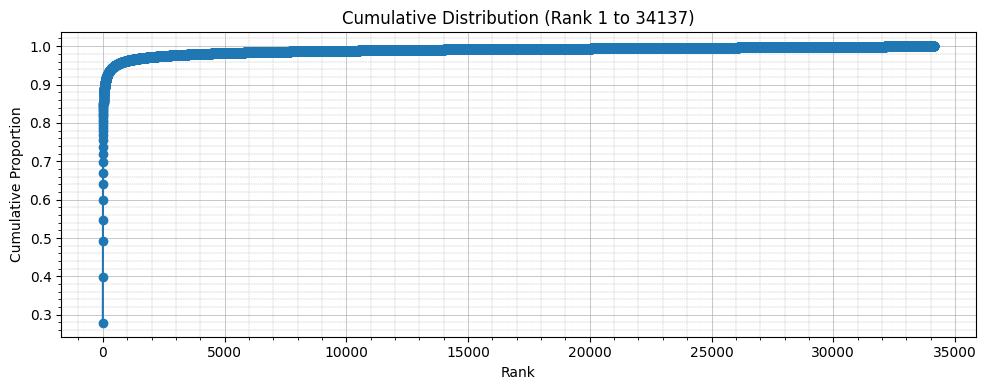

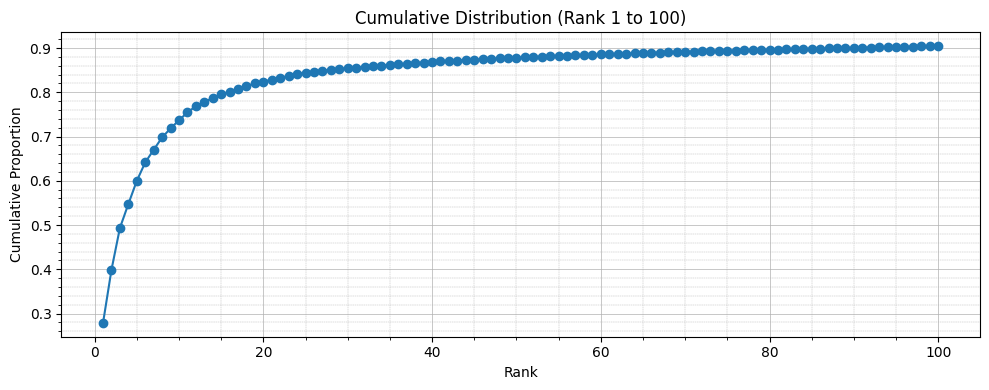

In [9]:
print("Number of different relationships:", len(relationship_counter))
# Plotting  the 100 most common relationships
plot_counter(relationship_counter, top_k=100)
plot_cumulative_counter(relationship_counter)
plot_cumulative_counter(relationship_counter, x_range=(0, 100))


### Distribution for Objects

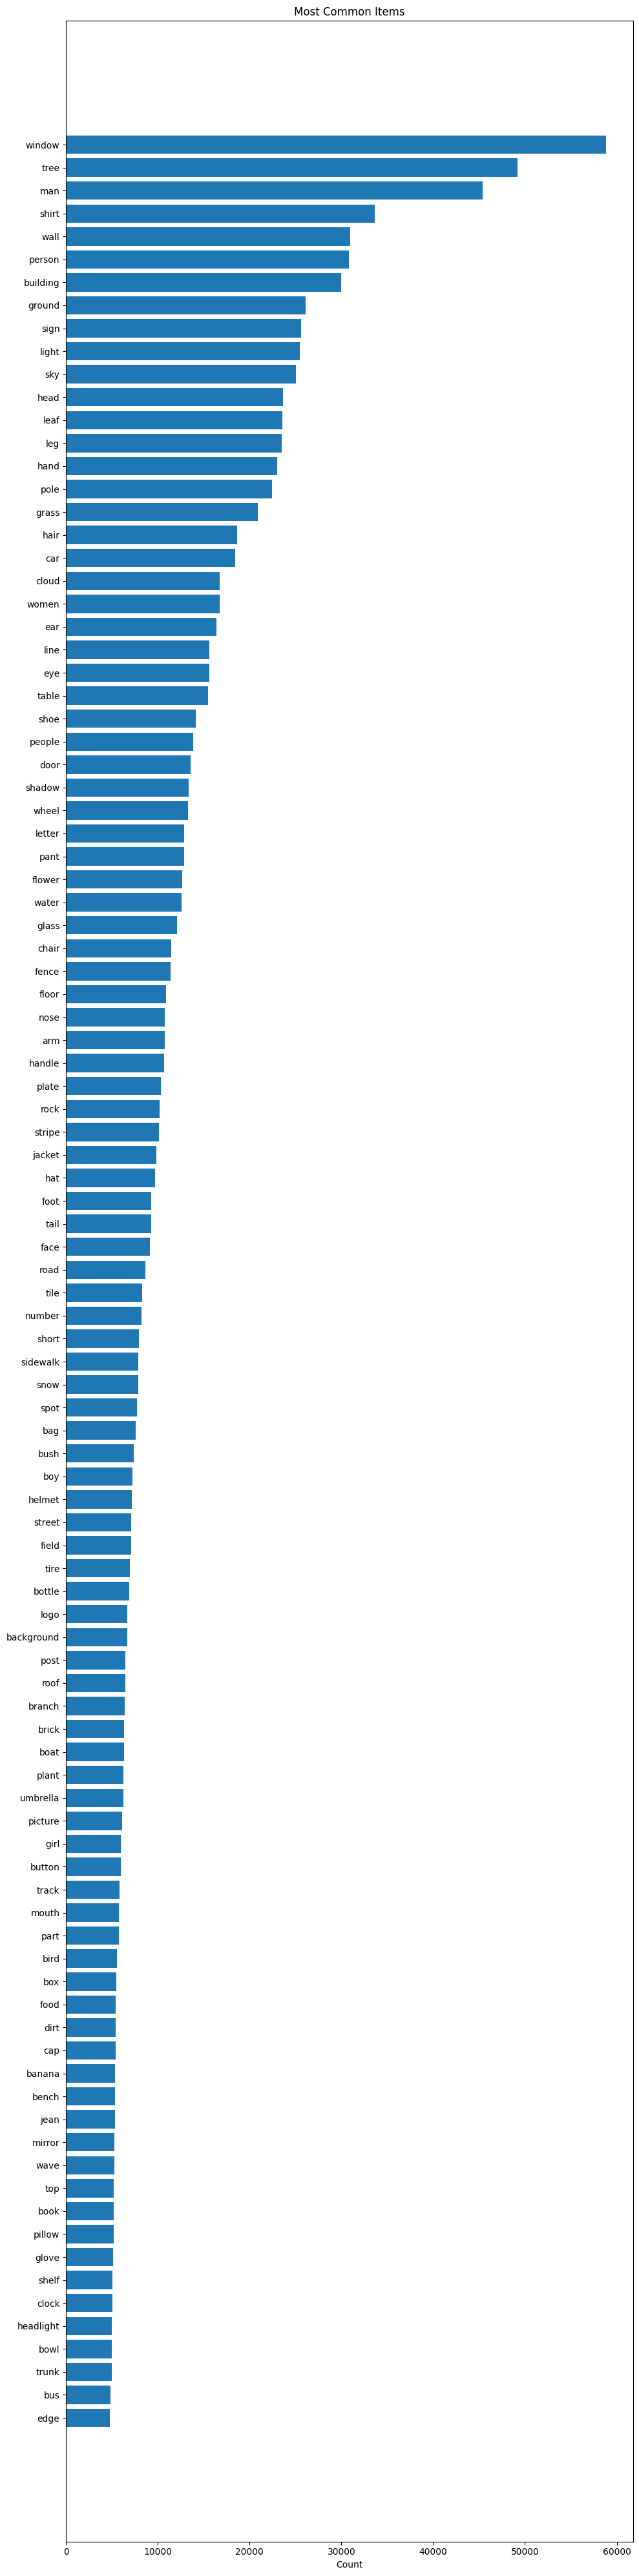

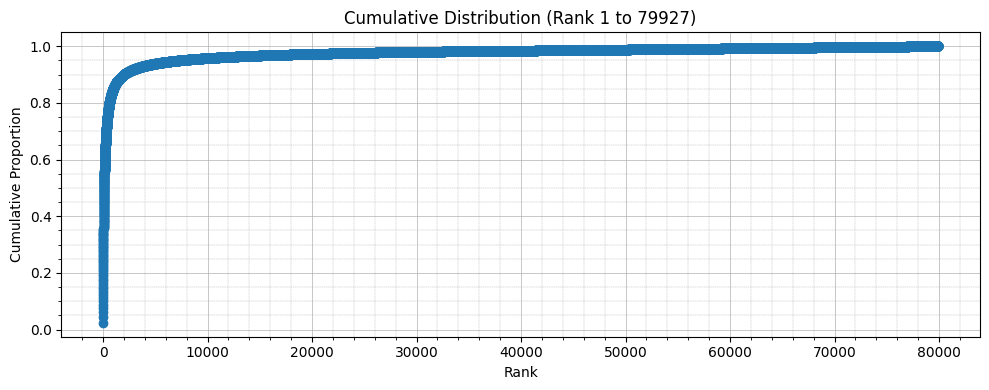

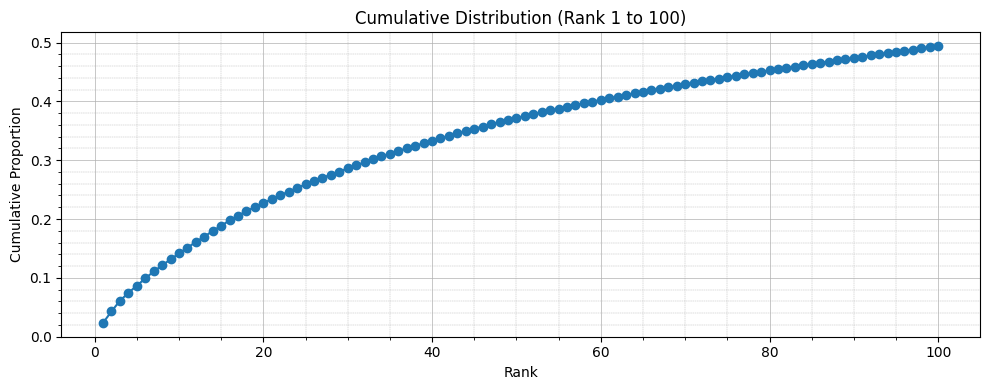

In [10]:
plot_counter(obj_counter, top_k=100)
plot_cumulative_counter(obj_counter)
plot_cumulative_counter(obj_counter, x_range=(0, 100))

# Distribution for Attributes

In [11]:
# count distribution of attributes for top objects
attr_counter = Counter()
for image_dict in tqdm(attributes_data):
    for attr in image_dict["attributes"]:
        for obj in attr["names"]:
            if "attributes" in attr:
                for attr_el in attr["attributes"]:
                    attr_counter[attr_el] += 1

100%|██████████| 108077/108077 [00:01<00:00, 60045.88it/s]


Number of different attributes: 80258


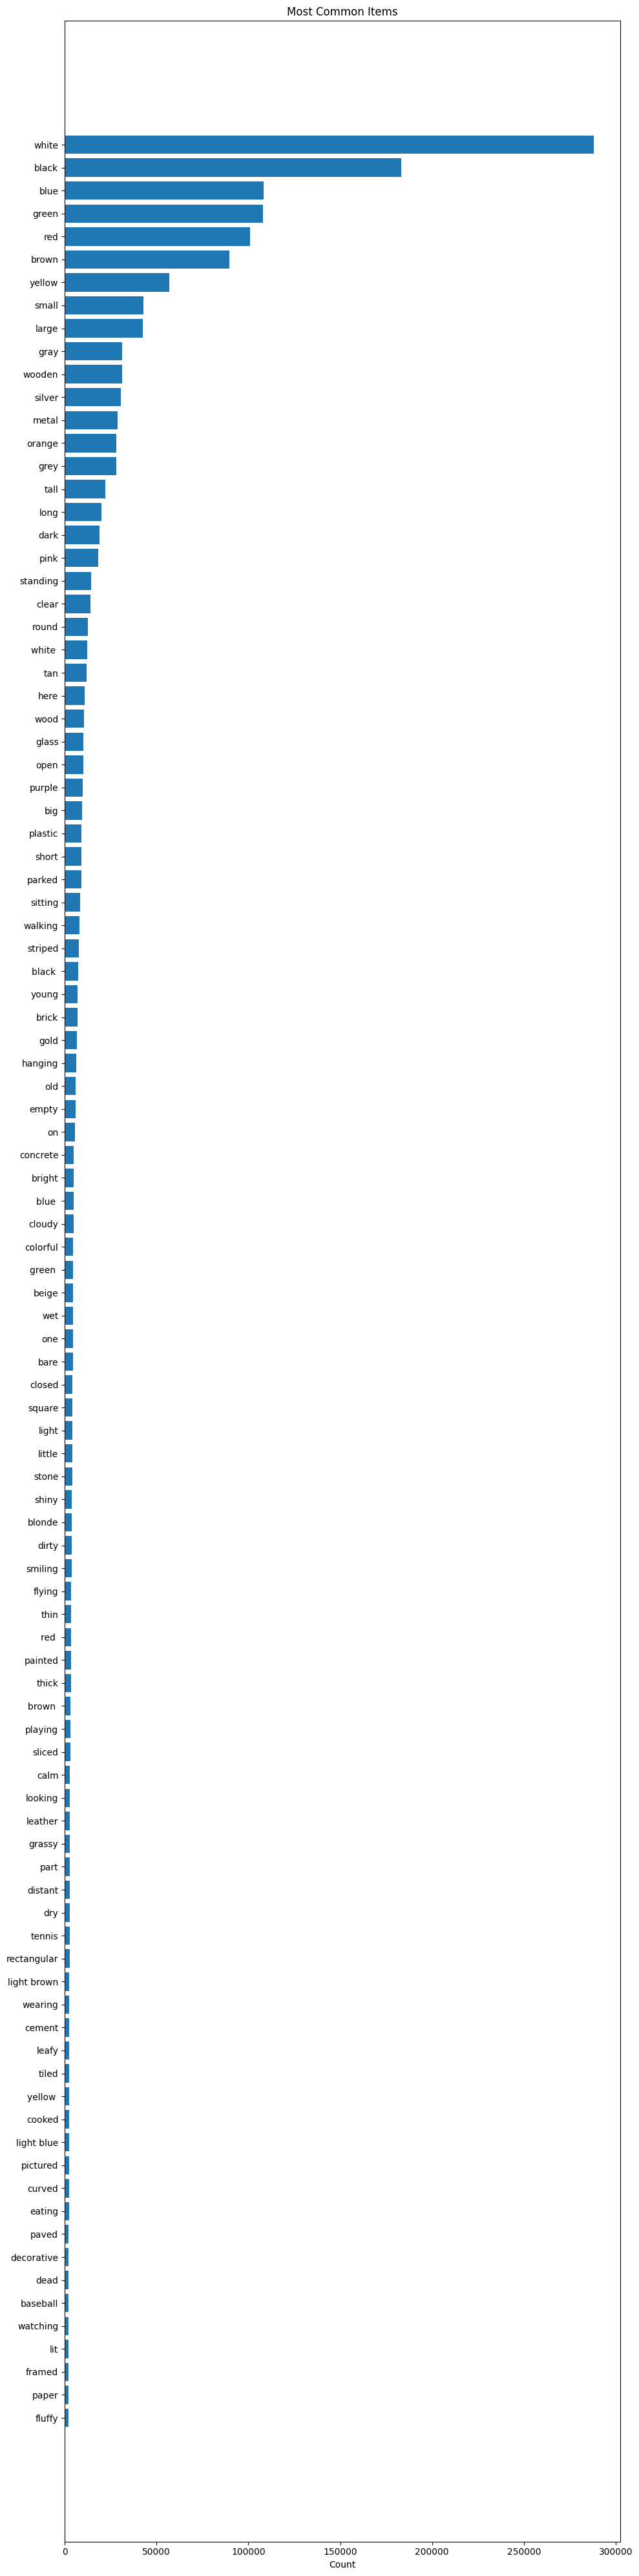

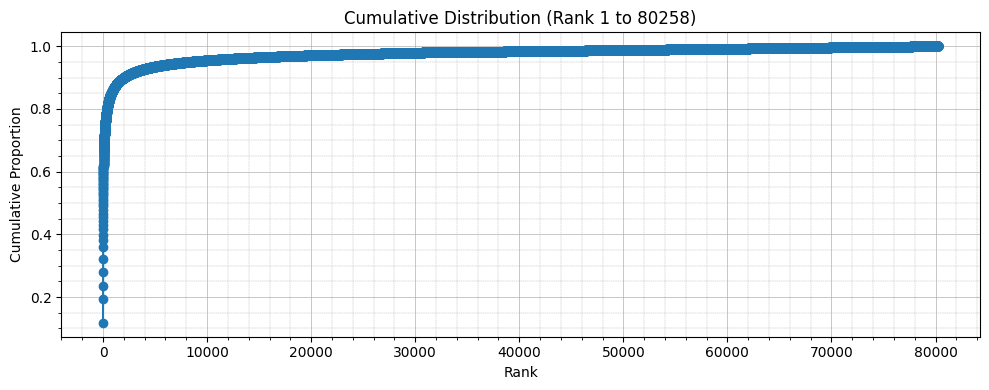

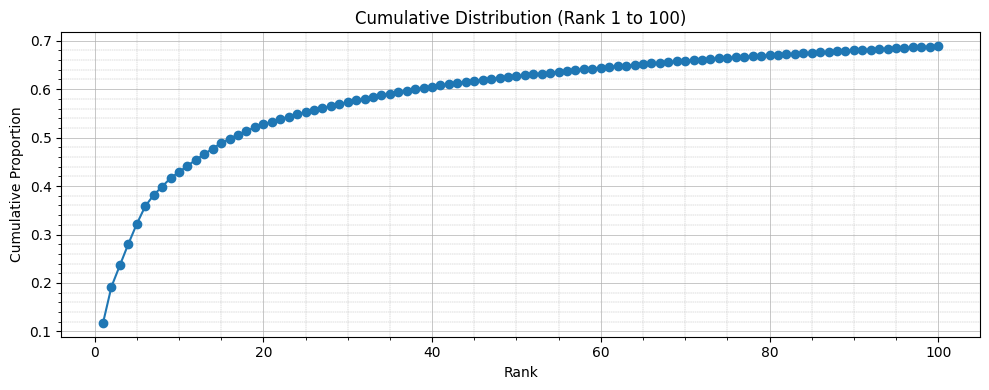

Top 20 attributes: [('white', 288110), ('black', 183234), ('blue', 108457), ('green', 107902), ('red', 100933), ('brown', 89510), ('yellow', 56867), ('small', 42764), ('large', 42503), ('gray', 31316), ('wooden', 31168), ('silver', 30463), ('metal', 28805), ('orange', 28012), ('grey', 28001), ('tall', 22251), ('long', 20158), ('dark', 19043), ('pink', 18397), ('standing', 14488)]


In [12]:
print("Number of different attributes:", len(attr_counter))
# Plotting  the 100 most common attributes
plot_counter(attr_counter, top_k=100)
plot_cumulative_counter(attr_counter)
plot_cumulative_counter(attr_counter, x_range=(0, 100))
# Check the most common attributes for the top objects
top_attributes = attr_counter.most_common(20)
print("Top 20 attributes:", top_attributes)

## Processing for dataset

In [13]:
im_id_to_info = {}

# Relationships
rel_counter = Counter()
for image in tqdm(relationships_data, desc="Processing relationships data"):
    image_id = image["image_id"]
    relationships = image["relationships"]
    im_id_to_info[image_id] = {"relationships": {}}
    for relationship in relationships:
        # Store the information in a dictionary
        canonical_predicate = relationship_alias_map.get(relationship["predicate"], relationship["predicate"])
        im_id_to_info[image_id]["relationships"][relationship["relationship_id"]] = { 
                "predicate": canonical_predicate,
                "subject": relationship["subject"]["object_id"],
                "object": relationship["object"]["object_id"]
                }
        rel_counter[relationship["predicate"]] += 1

# Objects
obj_counter = Counter()
for image in tqdm(objects_data, desc="Processing objects data"):
    image_id = image["image_id"]
    objects = image["objects"]
    im_id_to_info[image_id]["objects"] = {}
    for obj in objects:
        obj_name = obj["names"][0]
        # canonicalize the object name
        canonical_obj = object_alias_map.get(obj_name, obj_name)
        im_id_to_info[image_id]["objects"][obj["object_id"]] = canonical_obj
        obj_counter[canonical_obj] += 1
        
        # Double check if there are multiple names for the same object_id
        if len(obj["names"]) > 1:
            print(f"More than one name for object_id {obj['object_id']}: {obj['names']}")
            raise ValueError(f"More than one name for object_id {obj['object_id']}: {obj['names']}")

# Attributes
attr_counter = Counter()
for image in tqdm(attributes_data, desc="Processing attributes data"):
    image_id = image["image_id"]
    attributes = image["attributes"]
    im_id_to_info[image_id]["attributes"] = {}
    for attr in attributes:        
        object_id = attr["object_id"]
        object_attributes = attr["attributes"] if "attributes" in attr else []
        if object_id not in im_id_to_info[image_id]["attributes"]:
            im_id_to_info[image_id]["attributes"][object_id] = set()
        im_id_to_info[image_id]["attributes"][object_id].update(object_attributes)
        for obj_attr in object_attributes:
            attr_counter[obj_attr] += 1

print("Final dictionary looking at image_id 1")
print("relationships: ", im_id_to_info[1]["relationships"])
print("objects: ", im_id_to_info[1]["objects"])
print("attributes: ", im_id_to_info[1]["attributes"])

K = 20
print(f"Top {K} relationships:", rel_counter.most_common(K))
print(f"Top {K} objects:", obj_counter.most_common(K))
print(f"Top {K} attributes:", attr_counter.most_common(K))


Processing relationships data:   4%|▍         | 4058/108077 [00:00<00:02, 40574.91it/s]

Processing attributes data: 100%|██████████| 108077/108077 [00:05<00:00, 19594.30it/s]


Final dictionary looking at image_id 1
relationships:  {15927: {'predicate': 'ON', 'subject': 5045, 'object': 1058534}, 15928: {'predicate': 'wears', 'subject': 1058529, 'object': 1058525}, 15929: {'predicate': 'has', 'subject': 5049, 'object': 5050}, 15930: {'predicate': 'ON', 'subject': 1058507, 'object': 1058508}, 15931: {'predicate': 'ON', 'subject': 5055, 'object': 1058534}, 15932: {'predicate': 'has', 'subject': 1058529, 'object': 1058511}, 15933: {'predicate': 'by', 'subject': 1058534, 'object': 1058539}, 15934: {'predicate': 'has', 'subject': 1058515, 'object': 5060}, 15935: {'predicate': 'has', 'subject': 1058529, 'object': 1058518}, 15936: {'predicate': 'ON', 'subject': 1058519, 'object': 1058534}, 15937: {'predicate': 'wears', 'subject': 1058529, 'object': 1058525}, 15938: {'predicate': 'has', 'subject': 1058532, 'object': 1058525}, 15939: {'predicate': 'has', 'subject': 1058529, 'object': 1058511}, 15940: {'predicate': 'wears', 'subject': 1058529, 'object': 1058528}, 15941:

In [14]:
num_objects = 20
num_relationships = 20
num_attributes = 20
topK_objects = [obj for obj, _ in obj_counter.most_common(num_objects)]
topK_predicates = [rel for rel, _ in rel_counter.most_common(num_relationships)]
topK_attributes = [attr for attr, _ in attr_counter.most_common(num_attributes)]
obj_token_to_idx = {obj: idx for idx, obj in enumerate(topK_objects)}
pred_token_to_idx = {pred: idx + len(topK_objects) for idx, pred in enumerate(topK_predicates)}
attr_token_to_idx = {attr: idx + len(topK_objects) + len(topK_predicates) for idx, attr in enumerate(topK_attributes)}
# all_tokens = topK_objects + topK_predicates + topK_attributes
# token_to_idx = {token: idx for idx, token in enumerate(all_tokens)}
# idx_to_token = {idx: token for token, idx in token_to_idx.items()}

nx_graphs = []
# i = -1
# stop_graph = 4
for image_id, image_info in tqdm(im_id_to_info.items()):
    # i += 1
    # if i < 4:
    #     continue
    # elif i >= stop_graph + 1:
    #     break 
    # print(i)
    
    # Create a new directed graph for each image
    G = nx.DiGraph()
    
    # Add nodes for objects
    added_object_ids = []
    for obj_id, obj_name in image_info["objects"].items():
        label = obj_token_to_idx.get(obj_name, -1)
        if label != -1:
            G.add_node(obj_id, label=label)
            added_object_ids.append(obj_id)
    
    # Add nodes for attributes
    for obj_id, attrs in image_info["attributes"].items():
        # First condition: check if the object is in the topK objects
        # Second condition: check if the object name (there are some attributes that have object id that is not existent in the objects... 🤔)
        if obj_id in added_object_ids:
            for attr in attrs:
                label = attr_token_to_idx.get(attr, -1) 
                if label != -1:
                    attr_node_id = f"{obj_id}_{attr}"
                    G.add_node(attr_node_id, label=label)
                    G.add_edge(obj_id, attr_node_id)
    
    # Add edges for relationships
    for rel_id, rel_info in image_info["relationships"].items():
        subject_id = rel_info["subject"]
        obj_id = rel_info["object"]
        if (subject_id in added_object_ids) and (obj_id in added_object_ids):
            predicate = rel_info["predicate"]
            rel_node_id = f"{subject_id}_{predicate}_{obj_id}"
                
            label = pred_token_to_idx.get(predicate, -1)
            if label != -1:
                G.add_node(rel_node_id, label=label)
                G.add_edge(subject_id, rel_node_id)
                G.add_edge(rel_node_id, obj_id)
    
    nx_graphs.append(G)
    # if len(nx_graphs) == 6:
    #     break
    

max_nodes = max(len(G.nodes) for G in nx_graphs)
min_nodes = min(len(G.nodes) for G in nx_graphs)
print("Min nodes in a graph:", min_nodes)
print("Max nodes in a graph:", max_nodes)    

100%|██████████| 108077/108077 [00:04<00:00, 23903.68it/s]


Min nodes in a graph: 0
Max nodes in a graph: 179


In [15]:
# Debug problematic graph
prob_graph = nx_graphs[-1]
print(prob_graph.nodes(data=True))
print(topK_objects)
print(topK_predicates)
print(topK_attributes)
print("light" in topK_attributes)

[(3422177, {'label': 10}), ('3422177_blue', {'label': 42})]
['window', 'tree', 'man', 'shirt', 'wall', 'person', 'building', 'ground', 'sign', 'light', 'sky', 'head', 'leaf', 'leg', 'hand', 'pole', 'grass', 'hair', 'car', 'cloud']
['ON', 'has', 'IN', 'OF', 'WEARING', 'with', 'behind', 'holding', 'on top of', 'on a', 'near', 'next to', 'has a', 'on', 'under', 'by', 'of a', 'wears', 'above', 'sitting on']
['white', 'black', 'blue', 'green', 'red', 'brown', 'yellow', 'small', 'large', 'wooden', 'gray', 'silver', 'metal', 'orange', 'grey', 'tall', 'long', 'dark', 'pink', 'clear']
False


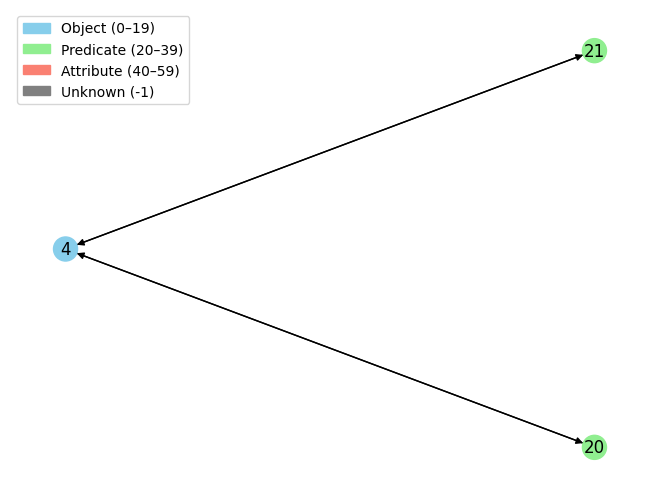

In [16]:
from matplotlib.patches import Patch
def draw_graph(G, seed=42):
    # pos = nx.spring_layout(G, seed=seed)
    # pos = nx.kamada_kawai_layout(G)
    pos = nx.shell_layout(G)
    labels = nx.get_node_attributes(G, 'label')

    # Define color map3
    color_map = {
        'object': 'skyblue',
        'predicate': 'lightgreen',
        'attribute': 'salmon',
        'unknown': 'gray'
    }

    # Assign colors to nodes
    node_colors = []
    for node in G.nodes():
        label = G.nodes[node].get('label', -1)
        if 0 <= label <= num_objects-1:
            node_colors.append(color_map['object'])
        elif num_objects <= label <= num_objects + num_relationships - 1:
            node_colors.append(color_map['predicate'])
        elif num_objects + num_relationships <= label <= num_objects + num_relationships + num_attributes - 1:
            node_colors.append(color_map['attribute'])
        else:
            node_colors.append(color_map['unknown'])

    # Draw graph
    nx.draw(G, pos, with_labels=True, labels=labels, node_color=node_colors)

    # Add legend
    legend_elements = [
        Patch(color=color_map['object'], label=f'Object (0–{num_objects-1})'),
        Patch(color=color_map['predicate'], label=f'Predicate ({num_objects}–{num_objects + num_relationships - 1})'),
        Patch(color=color_map['attribute'], label=f'Attribute ({num_objects + num_relationships}–{num_objects + num_relationships + num_attributes - 1})'),
        Patch(color=color_map['unknown'], label='Unknown (-1)')
    ]
    plt.legend(handles=legend_elements, loc='best')
    plt.show()

draw_graph(nx_graphs[40])

In [17]:
# Necessary conditions:
# For objects: out edges to attributes or relationships, in edges from relationships
# For relationships: in edges from objects, out edges to objects
# For attributes: in edges from objects, no out edges to objects
def is_object(node_label):
    return 0 <= node_label < num_objects
def is_relationship(node_label):
    return num_objects <= node_label < num_objects + num_relationships
def is_attribute(node_label):
    return num_objects + num_relationships <= node_label < num_objects + num_relationships + num_attributes


def scene_graph_validity(G):
    # print(G.nodes(data=True))

    for node_idx, node in enumerate(G.nodes()):
        # print(node_idx, node)

        # Object node
        if is_object(G.nodes[node]['label']):  
            out_edges = list(G.out_edges(node))
            in_edges = list(G.in_edges(node))
            for _, target in out_edges:
                if is_object(G.nodes[target]['label']):
                    return False
            for source, _ in in_edges:
                if not is_relationship(G.nodes[source]['label']):
                    return False
            # print("Passed object node check")
        
        # Relationship node
        elif is_relationship(G.nodes[node]['label']):
            out_edges = list(G.out_edges(node))
            in_edges = list(G.in_edges(node))
            if len(out_edges) != 1:
                return False
            if len(in_edges) != 1:
                return False
            source, _ = in_edges[0]
            _, target = out_edges[0]
            if not is_object(G.nodes[target]['label']) or not is_object(G.nodes[source]['label']):
                return False
            # print("Passed relationship node check")

        # Attribute node
        elif is_attribute(G.nodes[node]['label']):
            out_edges = list(G.out_edges(node))
            in_edges = list(G.in_edges(node))
            if len(out_edges) > 0:
                return False
            if len(in_edges) != 1:
                return False
            source, _ = in_edges[0]
            if not is_object(G.nodes[source]['label']):
                return False
            # print("Passed attribute node check")

        # Error
        else:
            raise ValueError(f"Node {node} has an invalid label: {G.nodes[node]['label']}")

    return True

num_invalid_graphs = 0
for graph in tqdm(nx_graphs):
    if not scene_graph_validity(graph):
        print(f"Graph {i} is invalid.")
        num_invalid_graphs += 1
print(f"Number of invalid graphs: {num_invalid_graphs}")


100%|██████████| 108077/108077 [00:19<00:00, 5408.55it/s] 

Number of invalid graphs: 0


In [18]:
# Check acyclicity
num_cyclic_graphs = 0 
for graph_idx, graph in enumerate(nx_graphs):
    if not nx.is_directed_acyclic_graph(graph):
        print(f"Graph {graph_idx} is cyclic.")
        num_cyclic_graphs += 1

print(f"Number of cyclic graphs: {num_cyclic_graphs}")

Graph 40 is cyclic.
Graph 47 is cyclic.
Graph 86 is cyclic.
Graph 157 is cyclic.
Graph 175 is cyclic.
Graph 189 is cyclic.
Graph 191 is cyclic.
Graph 193 is cyclic.
Graph 214 is cyclic.
Graph 235 is cyclic.
Graph 242 is cyclic.
Graph 261 is cyclic.
Graph 271 is cyclic.
Graph 282 is cyclic.
Graph 290 is cyclic.
Graph 297 is cyclic.
Graph 340 is cyclic.
Graph 345 is cyclic.
Graph 346 is cyclic.
Graph 363 is cyclic.
Graph 376 is cyclic.
Graph 430 is cyclic.
Graph 431 is cyclic.
Graph 455 is cyclic.
Graph 464 is cyclic.
Graph 470 is cyclic.
Graph 538 is cyclic.
Graph 545 is cyclic.
Graph 581 is cyclic.
Graph 593 is cyclic.
Graph 596 is cyclic.
Graph 640 is cyclic.
Graph 653 is cyclic.
Graph 654 is cyclic.
Graph 655 is cyclic.
Graph 665 is cyclic.
Graph 700 is cyclic.
Graph 703 is cyclic.
Graph 712 is cyclic.
Graph 728 is cyclic.
Graph 732 is cyclic.
Graph 736 is cyclic.
Graph 742 is cyclic.
Graph 746 is cyclic.
Graph 749 is cyclic.
Graph 753 is cyclic.
Graph 765 is cyclic.
Graph 778 is cyc

In [19]:
# Find cycles
idx_to_inspect = 40

graph = nx_graphs[idx_to_inspect]
cycle = nx.find_cycle(graph, orientation='original')
print("Cycle found:")
print(cycle)

Cycle found:
[(1061575, '1061575_ON_1061575', 'forward'), ('1061575_ON_1061575', 1061575, 'forward')]


#### Stats on the dataset

In [20]:
# mean number of nodes, mean number of edges
# max number of nodes, max number of edges
# min number of nodes, min number of edges

# number of nodes
max_nodes = max(len(G.nodes) for G in nx_graphs)
mean_nodes = sum(len(G.nodes) for G in nx_graphs) / len(nx_graphs)
min_nodes = min(len(G.nodes) for G in nx_graphs)
print("Max number of nodes:", max_nodes)
print("Mean number of nodes:", mean_nodes)
print("Min number of nodes:", min_nodes)

# number of edges
max_edges = max(len(G.edges) for G in nx_graphs)
mean_edges = sum(len(G.edges) for G in nx_graphs) / len(nx_graphs)
min_edges = min(len(G.edges) for G in nx_graphs)
print("Max number of edges:", max_edges)
print("Mean number of edges:", mean_edges)
print("Min number of edges:", min_edges)

Max number of nodes: 179
Mean number of nodes: 7.805175939376555
Min number of nodes: 0
Max number of edges: 134
Mean number of edges: 3.232796987333105
Min number of edges: 0


[(1058549, {'label': 1}), (1058508, {'label': 6}), (1058543, {'label': 4}), (1058545, {'label': 1}), (3798579, {'label': 0}), (3798576, {'label': 2}), (3798577, {'label': 2}), (1058507, {'label': 8}), (1058515, {'label': 18}), (5049, {'label': 18}), (1058511, {'label': 3}), (1058547, {'label': 3}), ('1058507_black', {'label': 41}), ('1058508_tall', {'label': 55}), ('1058511_orange', {'label': 53}), ('1058511_red', {'label': 44}), ('1058515_white', {'label': 40}), ('1058543_grey', {'label': 54}), ('1058547_grey', {'label': 54}), ('1058507_ON_1058508', {'label': 20}), ('1058508_with_3798579', {'label': 25})]
21
Edge index shape: torch.Size([2, 11])
Edge index: tensor([[ 1,  1,  2,  7,  7,  8, 10, 10, 11, 19, 20],
        [13, 20, 17, 12, 19, 16, 14, 15, 18,  1,  4]])
Node features shape: torch.Size([21])
Node features: tensor([ 1,  6,  4,  1,  0,  2,  2,  8, 18, 18,  3,  3, 41, 55, 53, 44, 40, 54,
        54, 20, 25])


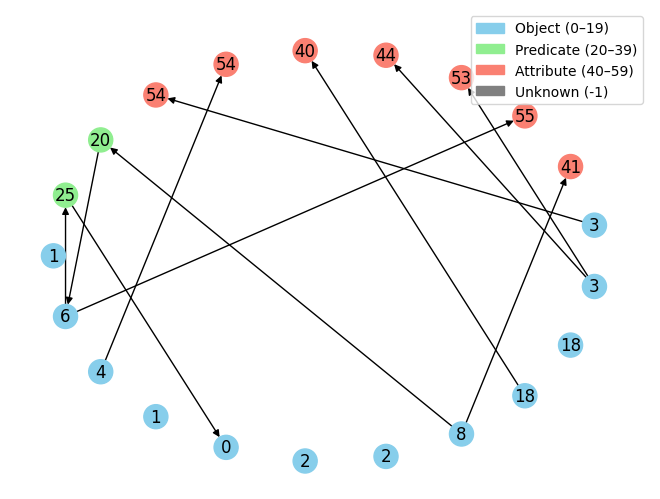

In [21]:
import torch_geometric.utils as pyg_utils

trial_graph = nx_graphs[0]

tg_graph = pyg_utils.from_networkx(trial_graph)
print(trial_graph.nodes(data=True))
print(trial_graph.number_of_nodes())
print("Edge index shape:", tg_graph.edge_index.shape)
print("Edge index:", tg_graph.edge_index)   
print("Node features shape:", tg_graph.label.shape)
print("Node features:", tg_graph.label)

draw_graph(trial_graph)